In [16]:
import geopandas as gpd
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB
from src.visualization import ee_viz
from src.data import mtbs
from src.data import shape_processor
from src.data import gedi_pipeline
from src.data import k_nn
import ee
import scipy.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from fitter import Fitter, get_common_distributions, get_distributions
from src.processing.recent_fires import gedi_matching, matching_analysis
from src.visualization.gedi_viz import geo_plot

import importlib
importlib.reload(gedi_pipeline)
importlib.reload(gedi_matching)
importlib.reload(matching_analysis)
from src.data.gedi_pipeline import get_severity

2023-06-07 12:04:57,979 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


In [2]:
ee.Authenticate()


Successfully saved authorization token.


In [2]:
ee.Initialize()

In [3]:
sierras = gpd.read_file("../../../data/shapefiles/sierras_convex_hull.shp")
firep_db = FirePerimetersDB('../../../data/fire_perimeters.gdb/')
sierra_firep = FirePerimeters(firep_db).filter_for_years(['2021']).filter_within_geometry(sierras)

In [4]:
gedi_gdf= gedi_pipeline.get_gedi_as_gdp('/maps/fire-regen/data/sierras_matched_lc_all_2x2.csv')
gedi_burned, gedi_unburned = gedi_pipeline.process_gedi_shots_for_recent_fires_analysis(gedi_gdf)

2023-06-07 11:29:46,595 DEBUG: Excluded shots on the burn boundaries, shots remaining:         9446235 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:58]
2023-06-07 11:29:46,898 DEBUG: Number of GEDI shots that burned at least once:                  1440937 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:63]
2023-06-07 11:29:48,024 DEBUG: Number of GEDI shots that never burned since 1984:         7852535 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:70]
2023-06-07 11:29:48,360 DEBUG: Number of shots that burned exactly once:                    1253729 [in exclude_shots_on_burn_boundaries at /home/jk871/fire-regen/src/data/gedi_pipeline.py:86]
2023-06-07 11:29:48,523 DEBUG: Number of GEDI shots that have a perfect match with burn                    raster (all 2x2 pixels have the same severity):                    771977 [in exclude_shots_on_burn_b

In [5]:
gedi_l2b = gedi_pipeline.get_gedi_as_gdp('/maps/fire-regen/data/gedi_l2b_sierras_matched_lc_all_2x2.csv')
gedi_burned_l2b, gedi_unburned_l2b = gedi_pipeline.process_gedi_shots_for_recent_fires_analysis(gedi_l2b)

2023-06-07 11:32:27,144 DEBUG: Excluded shots on the burn boundaries, shots remaining:         14968077 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:58]
2023-06-07 11:32:27,667 DEBUG: Number of GEDI shots that burned at least once:                  2184975 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:63]
2023-06-07 11:32:29,972 DEBUG: Number of GEDI shots that never burned since 1984:         12539296 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:70]
2023-06-07 11:32:30,756 DEBUG: Number of shots that burned exactly once:                    1891695 [in exclude_shots_on_burn_boundaries at /home/jk871/fire-regen/src/data/gedi_pipeline.py:86]
2023-06-07 11:32:31,079 DEBUG: Number of GEDI shots that have a perfect match with burn                    raster (all 2x2 pixels have the same severity):                    1192212 [in exclude_shots_on_bur

In [6]:
fire = sierra_firep.get_fire('KNP Complex')

In [7]:
matches = gedi_matching.match_measurements_before_and_after_fire(fire, gedi_burned, 'agbd')

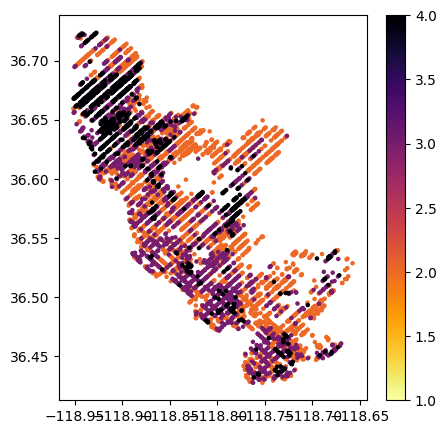

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
geo_plot(matches, ax, 'burn_severity_median', vmin=1, vmax=4)

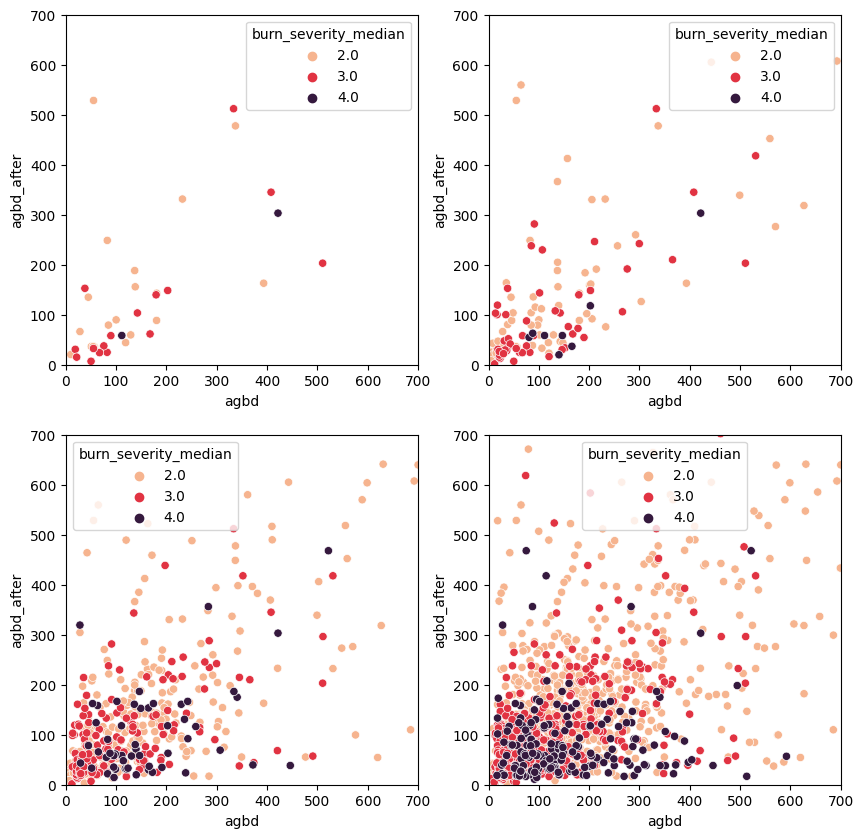

In [11]:
matching_analysis.plot_severity_for_distance(matches, 'agbd')

/maps-priv/maps/fire-regen/fire-regen-env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


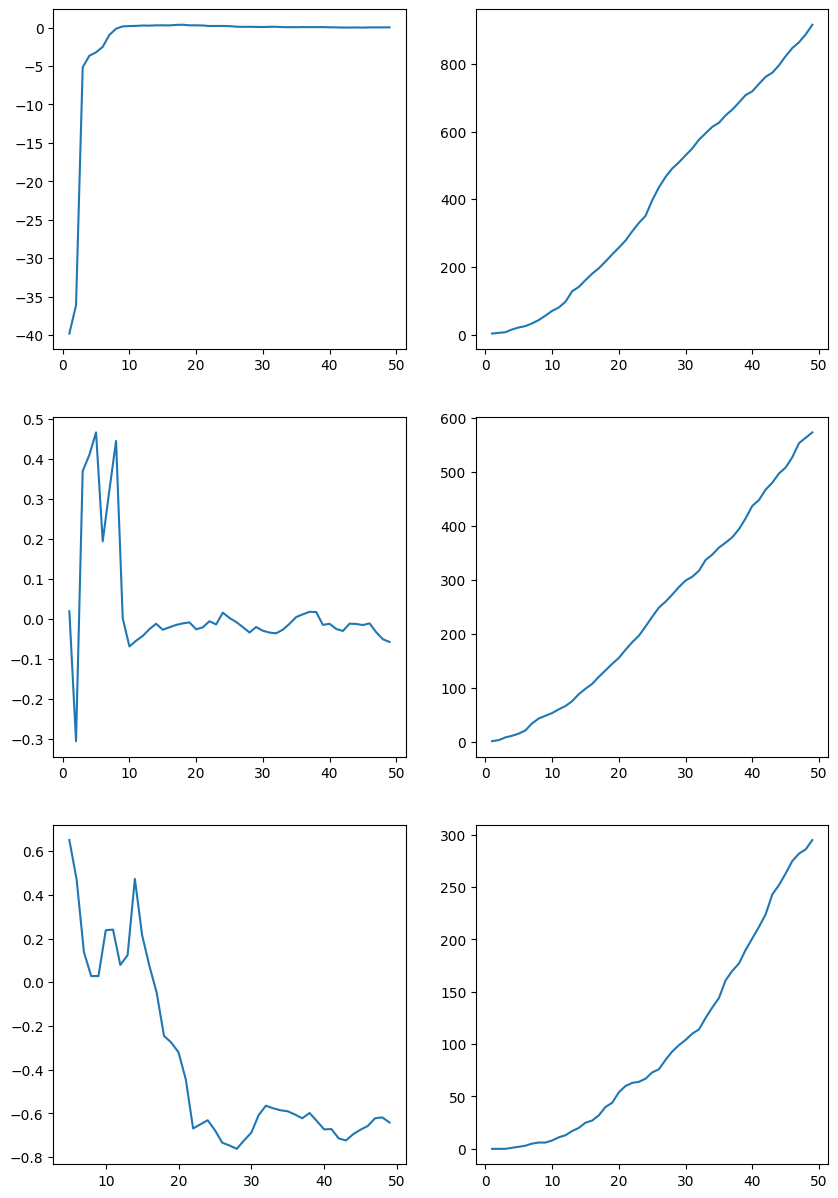

In [13]:
matching_analysis.plot_error_for_distances(matches, 'agbd')

In [14]:
def filter_land_cover(df):
    return df[(df.land_cover_std == 0) & (df.land_cover_mean == 1) & (df.pft_class == 1)]

In [15]:
close_matches = filter_land_cover(matches[matches.closest_distance < 20])

Linear regression fit for severity 2.
Best Linear regression coefficient is [0.53509433].         R squared is : 0.3377927610751724.
The error for coeff = 1 is: 0.21304243576786697.
Linear regression fit for severity 3.
Best Linear regression coefficient is [0.06479699].         R squared is : 0.020764142564628663.
The error for coeff = 1 is: -0.13466889302430873.
Linear regression fit for severity 4.
Best Linear regression coefficient is [0.37052408].         R squared is : 0.194567098628585.
The error for coeff = 1 is: -0.282923965039094.


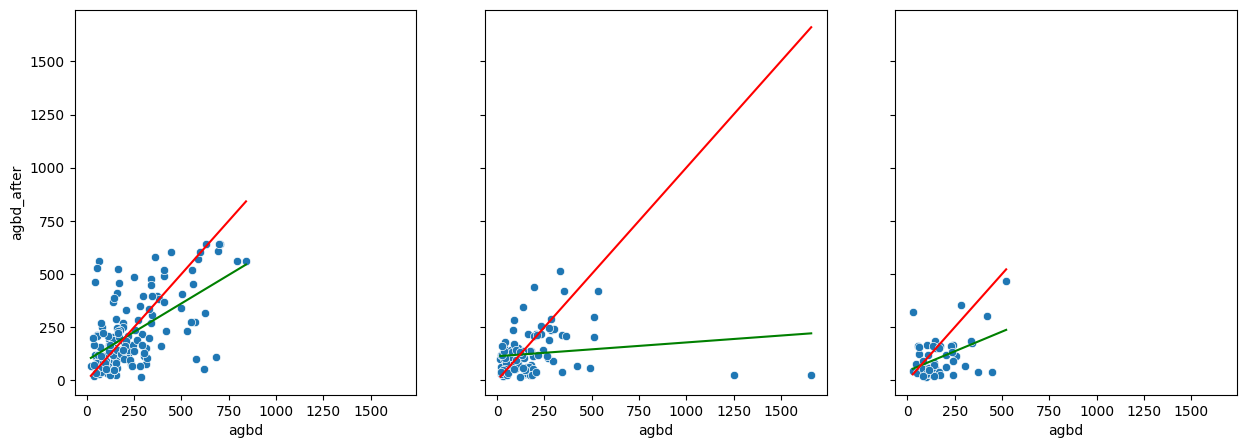

In [16]:
matching_analysis.fit_linear_regression_per_severity(close_matches, 'agbd')

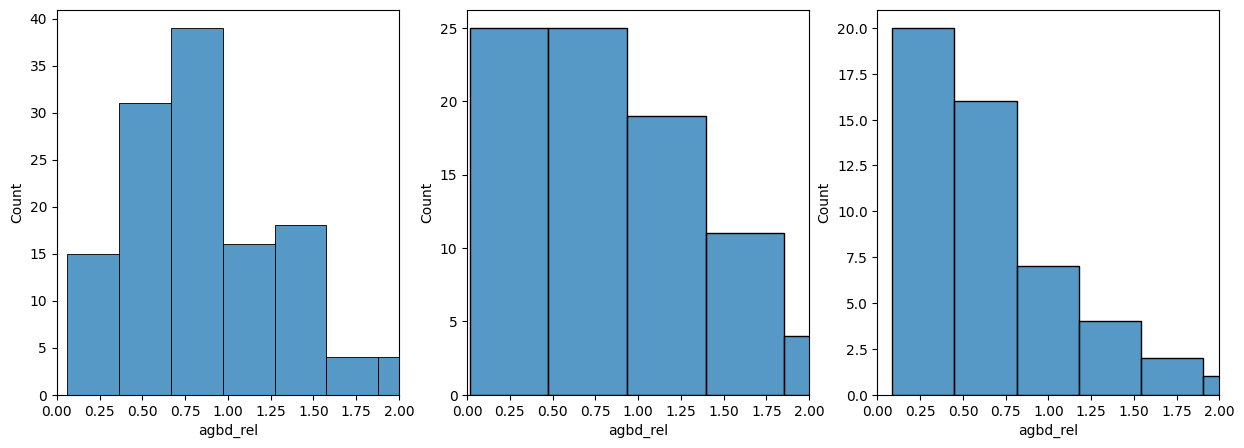

In [17]:
matching_analysis.plot_rel_difference_per_severity(close_matches, 'agbd')

### Fit distribution

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  8.17it/s]


         sumsquare_error          aic          bic  kl_div  ks_statistic  \
norm            0.000062  1587.669174 -2146.785971     inf      0.107916   
beta            0.000062  1590.612106 -2136.748791     inf      0.106251   
gamma           0.000063  1587.064832 -2141.194027     inf      0.103874   
lognorm         0.000427  1812.173612 -1859.304223     inf      0.752345   
burr            0.000521  1767.887542 -1824.917287     inf      0.673845   

            ks_pvalue  
norm     6.040945e-02  
beta     6.718503e-02  
gamma    7.797324e-02  
lognorm  1.011427e-86  
burr     1.686970e-66  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 23.64it/s]


{'norm': {'loc': 17.38214363046244, 'scale': 157.17627292529306}}


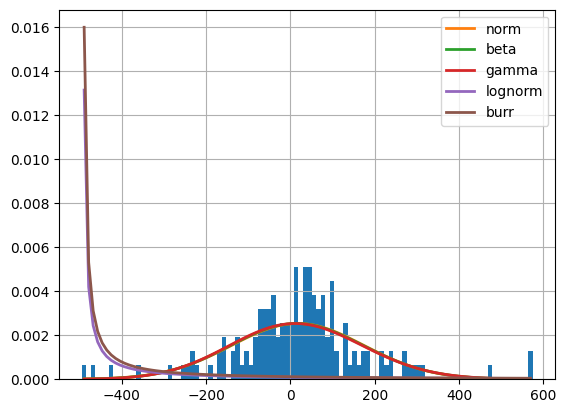

In [18]:
matching_analysis.fit_distributions(get_severity(close_matches, 2), 'agbd')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 10.54it/s]


         sumsquare_error          aic          bic  kl_div  ks_statistic  \
beta            0.000266  1767.008263 -1293.035893     inf      0.167121   
gamma           0.000267  1762.619606 -1297.111658     inf      0.180129   
norm            0.000269  1744.890709 -1300.930152     inf      0.163681   
lognorm         0.000812  1786.937967 -1183.688523     inf      0.794762   
burr            0.000874  1751.699845 -1171.540699     inf      0.709107   

            ks_pvalue  
beta     5.857730e-03  
gamma    2.285866e-03  
norm     7.423164e-03  
lognorm  1.566999e-69  
burr     3.339677e-52  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 27.23it/s]


{'norm': {'loc': 58.31384722391764, 'scale': 112.2860504110404}}


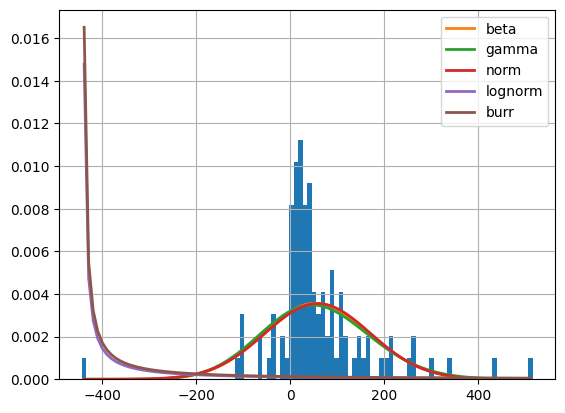

In [111]:
matching_analysis.fit_distributions(get_severity(close_matches, 3), 'agbd')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 11.43it/s]


         sumsquare_error          aic         bic  kl_div  ks_statistic  \
gamma           0.000464  1398.153034 -530.151665     inf      0.065442   
beta            0.000464  1399.461188 -526.281678     inf      0.065739   
norm            0.000534  1441.930547 -527.378116     inf      0.151840   
lognorm         0.001630  1678.831472 -471.094045     inf      0.699866   
burr            0.001739  1618.662475 -464.218613     inf      0.535917   

            ks_pvalue  
gamma    9.799540e-01  
beta     9.790537e-01  
norm     2.064718e-01  
lognorm  1.342721e-23  
burr     3.806278e-13  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 30.08it/s]


{'norm': {'loc': 129.4534209839841, 'scale': 124.69034455144067}}


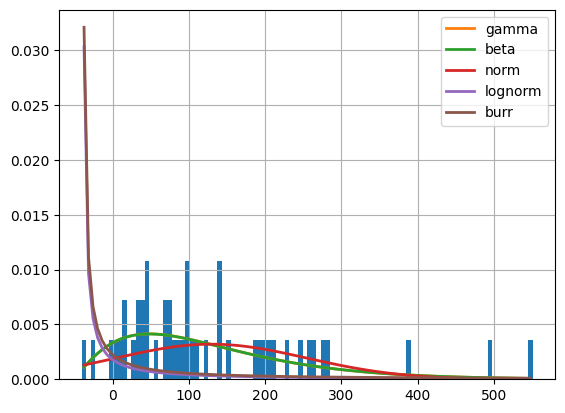

In [112]:
matching_analysis.fit_distributions(get_severity(close_matches, 4), 'agbd')

### Stat tests

In [113]:
matching_analysis.two_sided_tests(get_severity(close_matches, 2), 'agbd')

Shapiro test results ShapiroResult(statistic=0.8801906704902649, pvalue=1.7245307558279993e-13)
Ttest results: TtestResult(statistic=0.3904896729450677, pvalue=0.6964930095722461, df=261)
Wilcoxon test results: WilcoxonResult(statistic=14759.0, pvalue=0.04445149416606761)


In [114]:
matching_analysis.two_sided_tests(get_severity(close_matches, 3), 'agbd')

Shapiro test results ShapiroResult(statistic=0.8467029333114624, pvalue=6.995472201509756e-09)
Ttest results: TtestResult(statistic=5.219231680552508, pvalue=9.630272752752117e-07, df=101)
Wilcoxon test results: WilcoxonResult(statistic=773.0, pvalue=6.119563423832334e-10)


In [115]:
matching_analysis.two_sided_tests(get_severity(close_matches, 4), 'agbd')

Shapiro test results ShapiroResult(statistic=0.8745905756950378, pvalue=0.0001224538718815893)
Ttest results: TtestResult(statistic=7.041409835832142, pvalue=7.898174912656163e-09, df=46)
Wilcoxon test results: WilcoxonResult(statistic=19.0, pvalue=4.362732397567015e-12)


## PAI Z analysis

In [8]:
matches_paiz = gedi_matching.match_pai_z_before_and_after_fire(fire, gedi_burned_l2b)

In [9]:
def l2b_filter_land_cover(df):
    return df[(df.land_cover_std == 0) & (df.land_cover_mean == 1)]

close_matches = l2b_filter_land_cover(matches_paiz[matches_paiz.closest_distance < 20])
close_matches['date_since'] = ((close_matches.match_datetime - fire.cont_date)/np.timedelta64(1, 'M')).astype(int)

In [10]:
unpacked = matching_analysis.transform_pai_z_data(close_matches)

(0.0, 13.0)

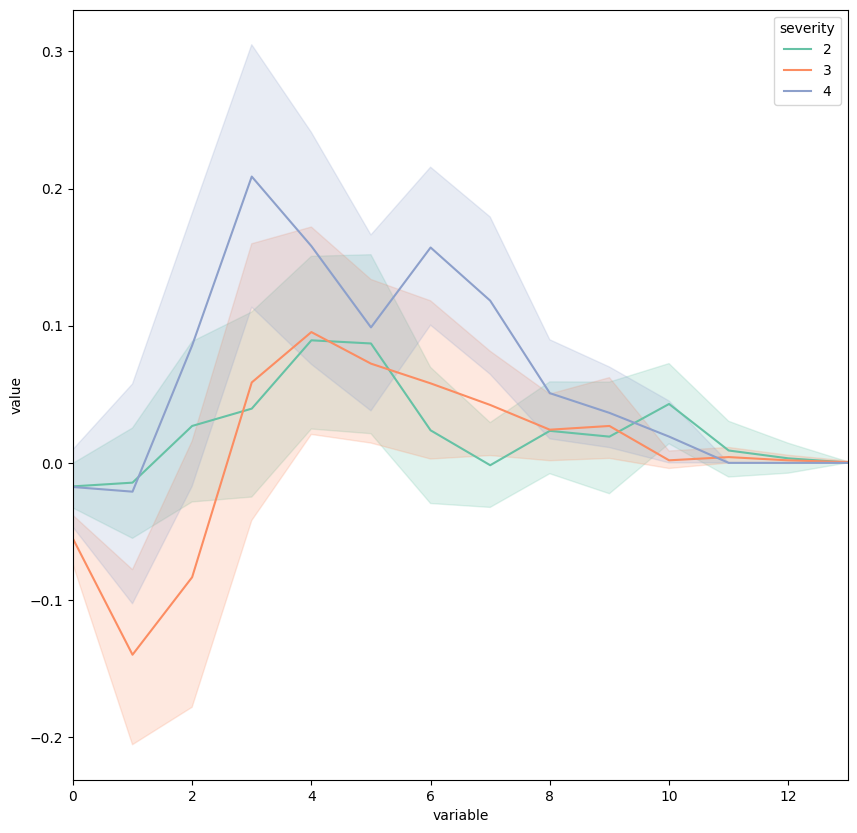

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot(unpacked, x='variable', y='value', hue='severity', ax=ax, palette='Set2')
ax.set_xlim((0, 13))

(0.0, 13.0)

<Figure size 2000x500 with 0 Axes>

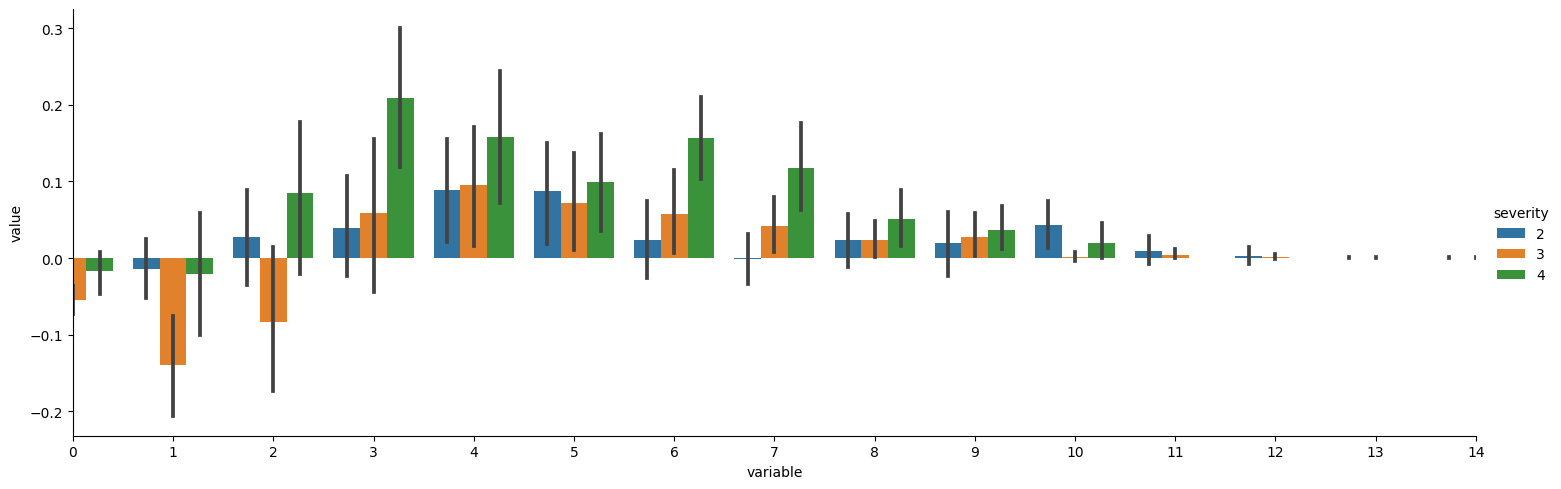

In [12]:
plt.figure(figsize=(20,5))
g = sns.catplot(unpacked, x='variable', y='value', hue='severity', kind='bar', height=5, aspect=3)
g.set(xlim=(0,14))
ax.set_xlim((0, 13))

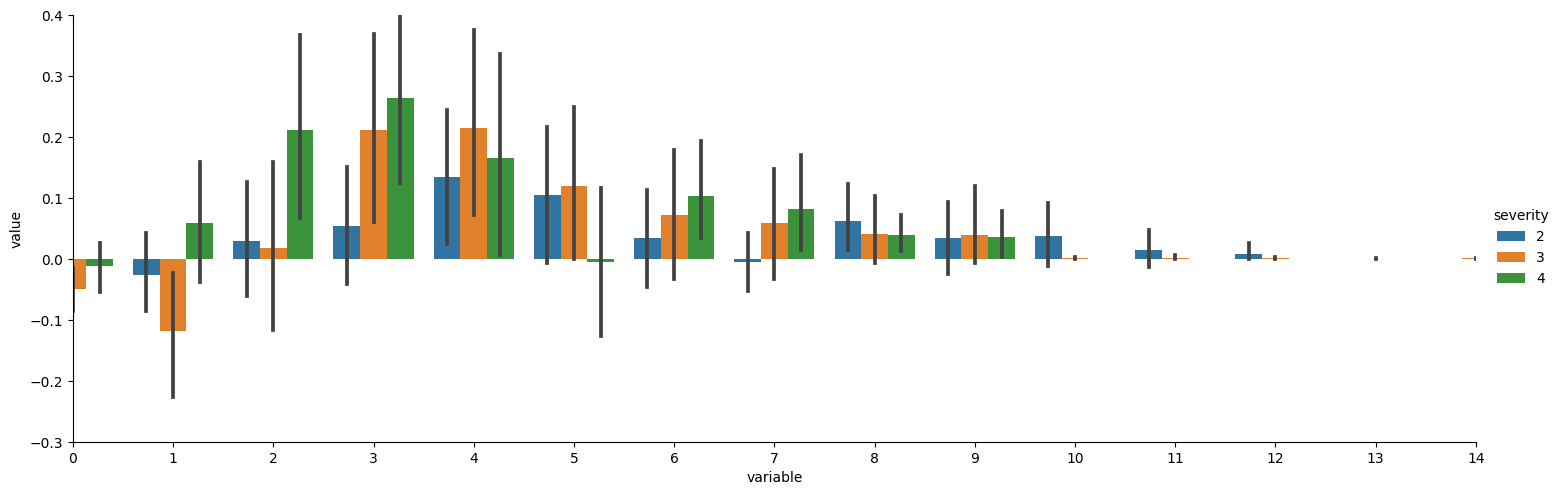

In [13]:
g = sns.catplot(unpacked[unpacked.date_since < 6], x='variable', y='value', hue='severity', kind='bar', height=5, aspect=3)
g.set(xlim=(0,14))
g.set(ylim=(-0.3, 0.4))

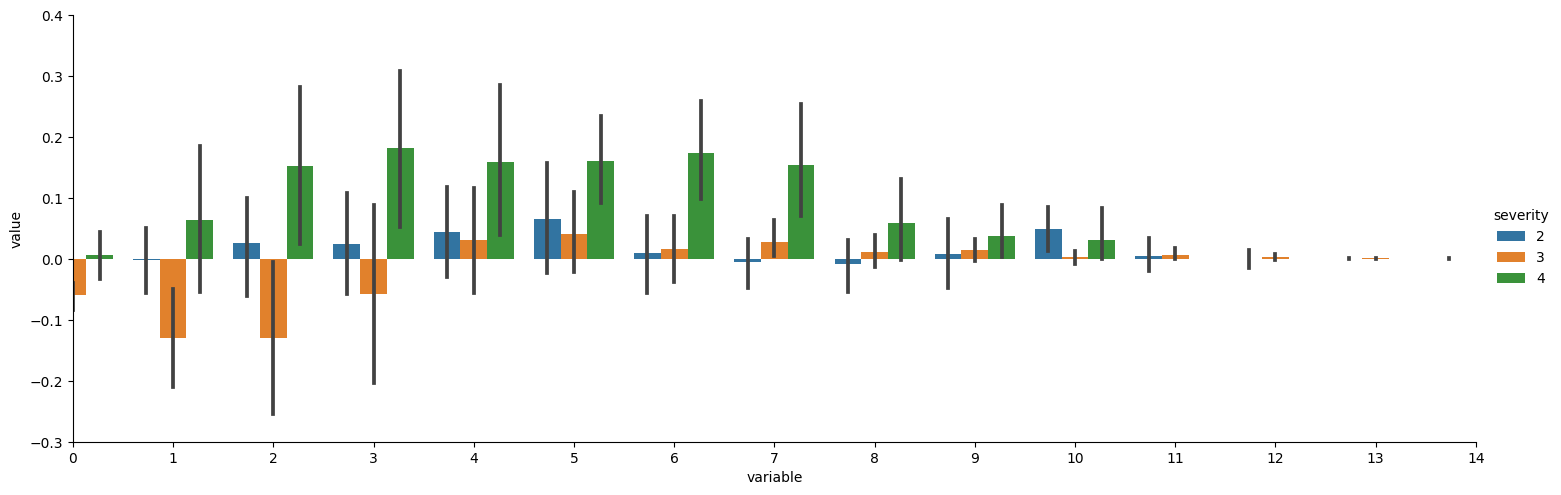

In [14]:
g = sns.catplot(unpacked[unpacked.date_since > 6], x='variable', y='value', hue='severity', kind='bar', height=5, aspect=3)
g.set(xlim=(0,14))
g.set(ylim=(-0.3, 0.4))

In [17]:
unpacked_granular = gedi_matching.add_date_since_burn_categories_granular(unpacked.reset_index())
unpacked_coarse = gedi_matching.add_date_since_burn_categories_coarse(unpacked.reset_index())

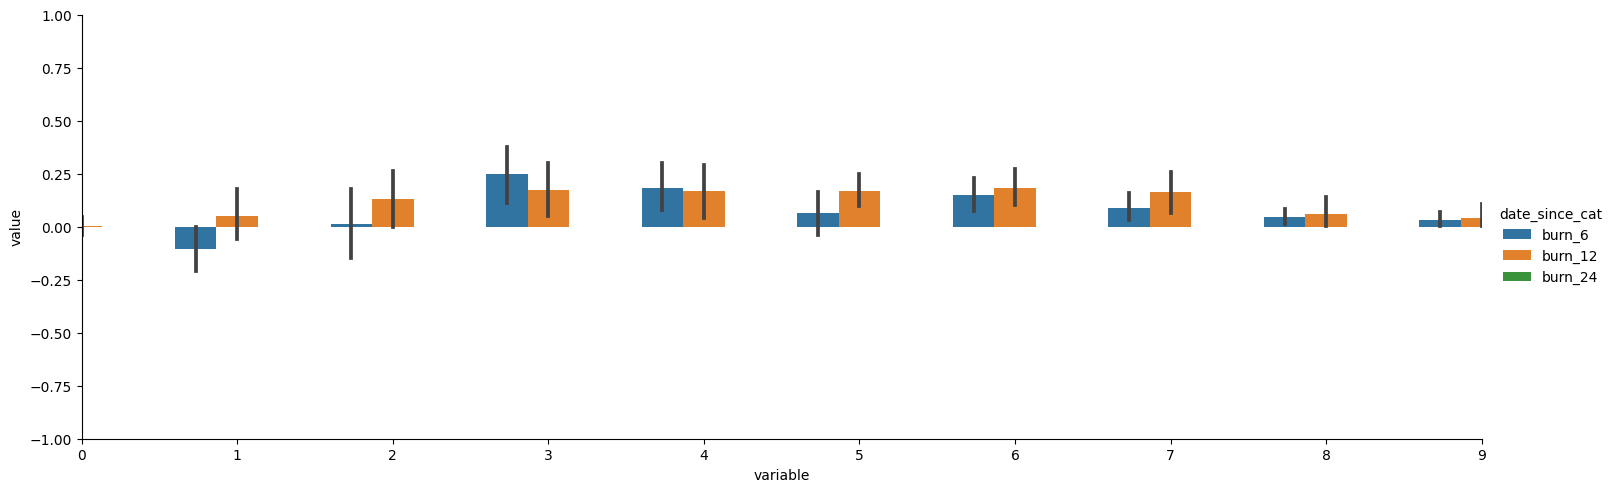

In [18]:
g = sns.catplot(unpacked_coarse[unpacked_coarse.severity==4], x='variable', y='value', hue='date_since_cat', kind='bar', height=5, aspect=3)
g.set(xlim=(0,9))
g.set(ylim=(-1,1))

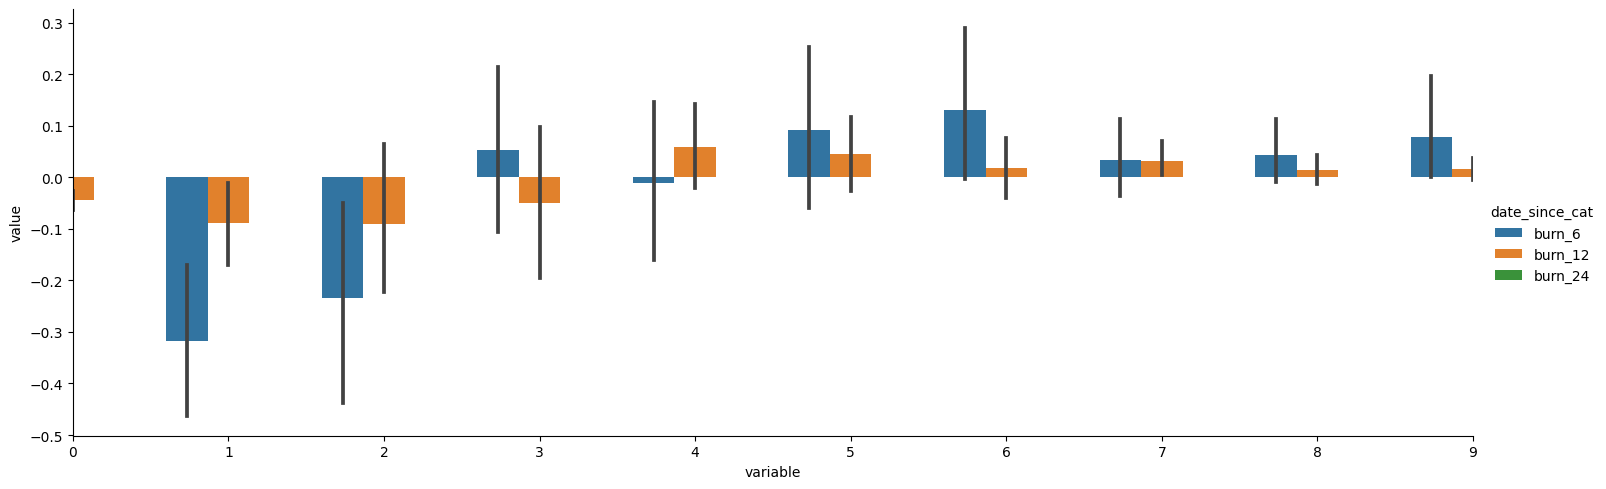

In [19]:
g = sns.catplot(unpacked_coarse[unpacked_coarse.severity==3], x='variable', y='value', hue='date_since_cat', kind='bar', height=5, aspect=3)
g.set(xlim=(0,9))
#g.set(ylim=(-1,1))

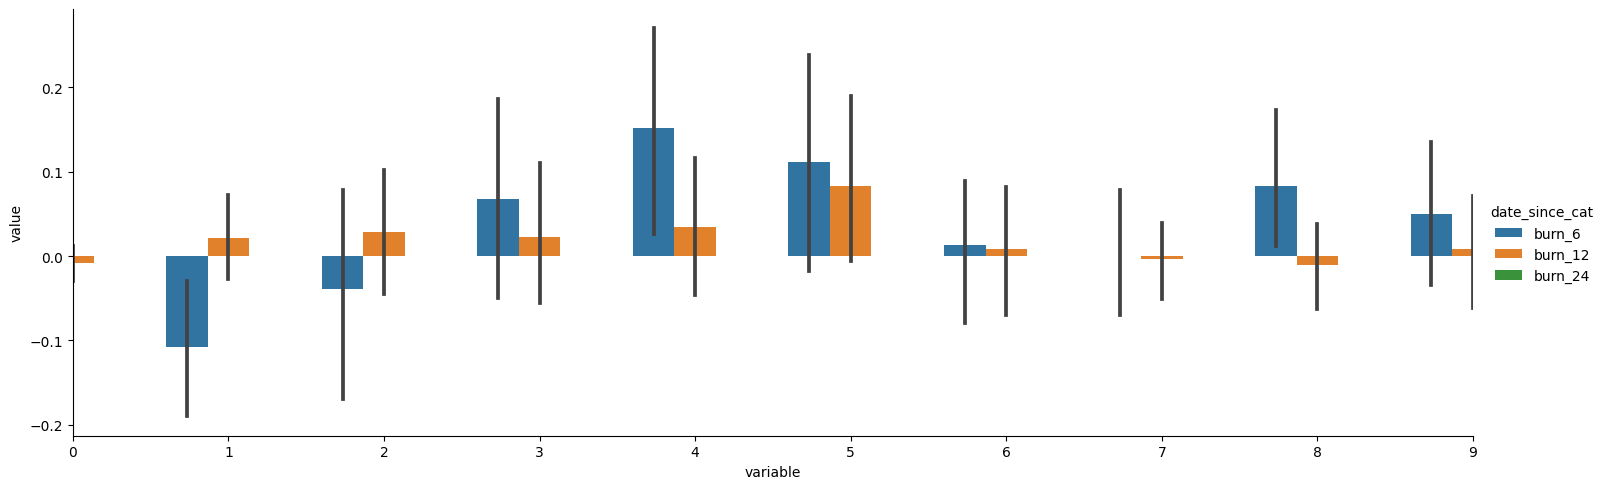

In [20]:
g = sns.catplot(unpacked_coarse[unpacked_coarse.severity==2], x='variable', y='value', hue='date_since_cat', kind='bar', height=5, aspect=3)
g.set(xlim=(0,9))
#g.set(ylim=(-1,1))